## Find Tandem Repeats

In some DNA sequences there are repeating patterns that are located directly next to one another. These are called [Tandem Repeats](https://en.wikipedia.org/wiki/Tandem_repeat) and are of some interest to biologists.


`ACGTACGTAAACGTAAACGTAAACGTGTGTACACCCAAAGTCA`

In the above sequence, `ACGTAA` is repeated three times. This might warrant a closer look?

Let's create a model that can detect repeated patterns within these sequences.

### Creating a dataset

We will create a dataset by 
 - Randomly generating sequences of 100 random base pairs 
 - Replacing elements of them with repeated patterns of 
   - Length 5-20. 
   - Patterns may be repeated 2-4 times.

In [5]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from radam import RAdam
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Config, GPT2PreTrainedModel, GPT2Model
from transformers import BertConfig, BertModel

In [193]:
DNA_BASE_LENGTH = 50
NUM_EXAMPLES = 10000
REPITION_LENGTH = 4
NUM_REPEATS = 3

train_seq = []
train_idx = np.zeros((NUM_EXAMPLES, DNA_BASE_LENGTH), dtype=np.int)

test = []

# Create 100 random sequences of DNA bases
for i, _ in enumerate(range(NUM_EXAMPLES)):
    
    dna_read = ''.join([random.choice('ACGT') for n in range(DNA_BASE_LENGTH)])
    
    # Build the repeated sequence
    repetition_length = random.randint(REPITION_LENGTH, REPITION_LENGTH)
    number_of_repeats = random.randint(NUM_REPEATS-1, NUM_REPEATS)
    repeated_sequence = ''.join([random.choice('ACGT') for n in range(repetition_length)]) * number_of_repeats
      
    # Choose where to place the repetition
    repeated_location = random.randint(0, len(dna_read) - len(repeated_sequence))

    test.append(repeated_location)
    
    # Insert the string
    new_dna_read = dna_read[0:repeated_location] + repeated_sequence + dna_read[repeated_location + len(repeated_sequence):]
    
    # Mark the indexes of the start of reptitions
    for j in range(number_of_repeats):
        #train_idx[i, repeated_location + (j * repetition_length)] = 1
        cur_loc = repeated_location + (j * repetition_length)
        train_idx[i, cur_loc:cur_loc+repetition_length] = 1
   
    train_seq.append(new_dna_read)

(array([1259.,  964., 1016.,  962.,  951., 1259.,  931.,  951.,  950.,
         757.]),
 array([ 0. ,  4.2,  8.4, 12.6, 16.8, 21. , 25.2, 29.4, 33.6, 37.8, 42. ]),
 <a list of 10 Patch objects>)

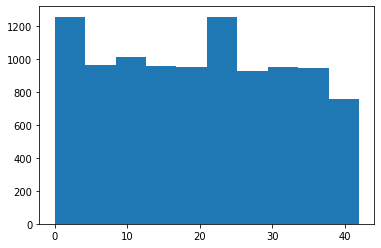

In [194]:
plt.hist(test)

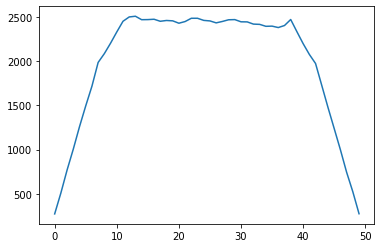

In [195]:
plt.plot(train_idx.sum(axis=0))

In [196]:
train_seq[0]

'CCAGCCAGCCAGCCGATAACCGGAATGGTAAATGGCGCTATTCCCGATTA'

In [197]:
train_idx[0]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [198]:
train_idx[:10]

array([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0

**TODO:** Handle accidentally repeated sequences. (For example we might have "CC" at the beginning or end of our sequence by chance)

## Train a model

In [200]:
class TandemRepeatDataset(Dataset):
    """
    A PyTorch Dataset that handles simple tokenization of our DNA base sequences.
    """
    
    def __init__(self, train_seq, train_idx):
        
        self.mapping = {'A':0, 'C': 1, 'G': 2, 'T': 3}
        self.train_seq = self.tokenize(train_seq)
        self.train_idx = train_idx
        
    def tokenize(self, train_seq):
        tokenized_seq = []
        
        for seq in train_seq:
            token_seq = [self.mapping[char] for char in seq]
            tokenized_seq.append(token_seq)
       
        return tokenized_seq
    
    def __getitem__(self, idx):
        
        x = torch.Tensor(self.train_seq[idx]).long()
        y = torch.Tensor(self.train_idx[idx]).long()
        return x, y
    
    def __len__(self):
        return len(self.train_seq)


In [201]:
BATCH_SIZE = 10

In [202]:
train_dataset = TandemRepeatDataset(train_seq, train_idx)
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [203]:
# GPT2 Model
#config = GPT2Config.from_pretrained('gpt2', cache_dir=None)
#model = GPT2Model.from_pretrained('gpt2', from_tf=False, config=config, cache_dir='.')

In [204]:
class TandemRepeatModel(torch.nn.Module):
    """
    Wrapper around a BERT model that predicts a single binary output for each input token
    """
    
    def __init__(self):
        super().__init__()
        
        # Untrained BERT Model
        config = BertConfig(vocab_size_or_config_json_file=4)
        self.bert_model = BertModel(config)

        self.linear =  torch.nn.Linear(in_features=768, out_features=2)
        
    def forward(self, x):    
        out, _ = self.bert_model(x)
        out = self.linear(out)
        return out    

In [225]:
# BERT Model
model = TandemRepeatModel()

In [226]:
optimizer = RAdam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [227]:
NUM_EPOCHS = 1000

for i in range(NUM_EPOCHS):
    
    for x, y in train_dl:
        
        model.zero_grad()
        output = model(x)
        loss = loss_fn(output.view((-1, output.size(-1))), y.view(-1))
        
        #print(output[0][:10])
        print(loss)
        
        #time.sleep(0.5)
        
        loss.backward()
        optimizer.step()

tensor(0.7983, grad_fn=<NllLossBackward>)
tensor(0.7952, grad_fn=<NllLossBackward>)
tensor(0.7929, grad_fn=<NllLossBackward>)
tensor(0.8051, grad_fn=<NllLossBackward>)
tensor(0.7806, grad_fn=<NllLossBackward>)
tensor(0.7839, grad_fn=<NllLossBackward>)
tensor(0.7274, grad_fn=<NllLossBackward>)
tensor(0.7225, grad_fn=<NllLossBackward>)
tensor(0.6729, grad_fn=<NllLossBackward>)
tensor(0.6571, grad_fn=<NllLossBackward>)
tensor(0.6402, grad_fn=<NllLossBackward>)
tensor(0.5987, grad_fn=<NllLossBackward>)
tensor(0.5690, grad_fn=<NllLossBackward>)
tensor(0.5559, grad_fn=<NllLossBackward>)
tensor(0.5609, grad_fn=<NllLossBackward>)
tensor(0.5519, grad_fn=<NllLossBackward>)
tensor(0.5608, grad_fn=<NllLossBackward>)
tensor(0.5324, grad_fn=<NllLossBackward>)
tensor(0.5034, grad_fn=<NllLossBackward>)
tensor(0.5319, grad_fn=<NllLossBackward>)
tensor(0.5210, grad_fn=<NllLossBackward>)
tensor(0.5451, grad_fn=<NllLossBackward>)
tensor(0.5569, grad_fn=<NllLossBackward>)
tensor(0.5766, grad_fn=<NllLossBac

KeyboardInterrupt: 

In [208]:
x, y = train_dataset[0]

In [211]:
x

tensor([1, 1, 0, 2, 1, 1, 0, 2, 1, 1, 0, 2, 1, 1, 2, 0, 3, 0, 0, 1, 1, 2, 2, 0,
        0, 3, 2, 2, 3, 0, 0, 0, 3, 2, 2, 1, 2, 1, 3, 0, 3, 3, 1, 1, 1, 2, 0, 3,
        3, 0])

In [213]:
y

tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [221]:
torch.softmax(model(x.unsqueeze(0)), dim=2)

tensor([[[0.9763, 0.0237],
         [0.9563, 0.0437],
         [0.9158, 0.0842],
         [0.9249, 0.0751],
         [0.9106, 0.0894],
         [0.8710, 0.1290],
         [0.8490, 0.1510],
         [0.8327, 0.1673],
         [0.8456, 0.1544],
         [0.8550, 0.1450],
         [0.8065, 0.1935],
         [0.8091, 0.1909],
         [0.8185, 0.1815],
         [0.8061, 0.1939],
         [0.8041, 0.1959],
         [0.7797, 0.2203],
         [0.8033, 0.1967],
         [0.8258, 0.1742],
         [0.8069, 0.1931],
         [0.7772, 0.2228],
         [0.8042, 0.1958],
         [0.7610, 0.2390],
         [0.8469, 0.1531],
         [0.7643, 0.2357],
         [0.7979, 0.2021],
         [0.7833, 0.2167],
         [0.7693, 0.2307],
         [0.7656, 0.2344],
         [0.8053, 0.1947],
         [0.7570, 0.2430],
         [0.7168, 0.2832],
         [0.7914, 0.2086],
         [0.8576, 0.1424],
         [0.7900, 0.2100],
         [0.7508, 0.2492],
         [0.8122, 0.1878],
         [0.8043, 0.1957],
 